In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import gensim
import nltk
import spacy
import re
import spacy
import matplotlib.pyplot as plt
import string
import math




from sklearn.model_selection import GridSearchCV
from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE


from spacy import displacy
from transformers import pipeline
from itertools import product

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


In [2]:
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
prompts_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
sample_submission = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
summaries_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")

# **Data Understanding**

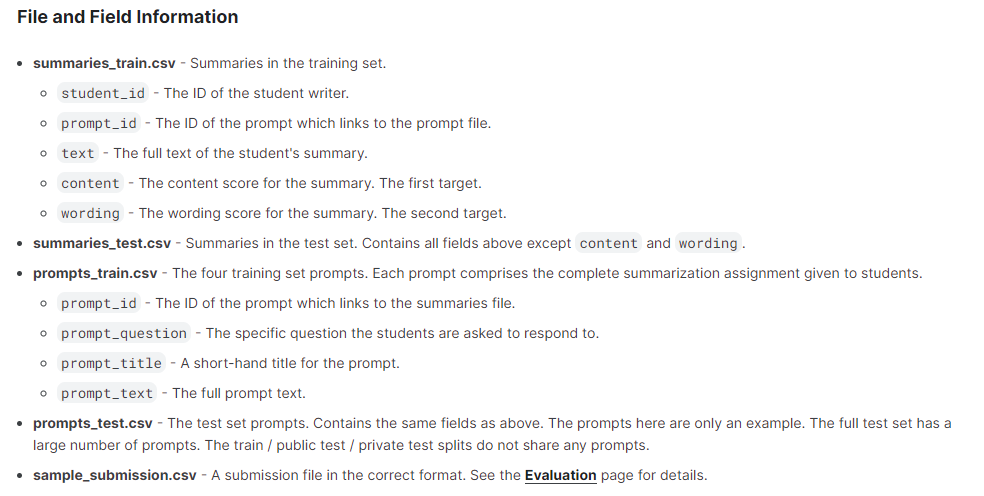

In [3]:
prompts_test.head()

prompt_id prompt_question     prompt_title       prompt_text
0    abc123    Summarize...  Example Title 1  Heading\nText...
1    def789    Summarize...  Example Title 2  Heading\nText...

In [4]:
prompts_train.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [5]:
sample_submission.head()

student_id  content  wording
0  000000ffffff      0.0      0.0
1  111111eeeeee      0.0      0.0
2  222222cccccc      0.0      0.0
3  333333dddddd      0.0      0.0

In [6]:
summaries_test.head()

student_id prompt_id            text
0  000000ffffff    abc123  Example text 1
1  111111eeeeee    def789  Example text 2
2  222222cccccc    abc123  Example text 3
3  333333dddddd    def789  Example text 4

In [7]:
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [8]:
prompts_test.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [9]:
prompts_train.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [10]:
sample_submission.dtypes

student_id     object
content       float64
wording       float64
dtype: object

In [11]:
summaries_test.dtypes

student_id    object
prompt_id     object
text          object
dtype: object

In [12]:
summaries_train.dtypes

student_id     object
prompt_id      object
text           object
content       float64
wording       float64
dtype: object

In [13]:
train_df = pd.merge(summaries_train, prompts_train, on="prompt_id", how="inner")
train_df.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  3.272894  3.219757  Summarize how the Third Wave developed over su...   
2  0.205683  0.380538  Summarize how the Third Wave developed over su...   
3  0.567975  0.969062  Summarize how the Third Wave developed over su...   
4 -0.910596 -0.081769  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  
0  The Third Wave  Background \r\nThe Third Wave experiment took ...  
1  The Third Wave  Background \r\nThe Third Wave experiment took ...  
2  The Third Wave  Background \r\nThe Third Wave experiment took ...  
3  The Third Wave  Background \r\nThe Third Wave experiment took ...  
4  The Third Wave  Background \r\nThe Third Wave experiment took ...

In [14]:
train_df.shape

(7165, 8)

In [15]:
test_df = pd.merge(summaries_test, prompts_test, on="prompt_id", how="inner")
test_df.head()

student_id prompt_id            text prompt_question     prompt_title  \
0  000000ffffff    abc123  Example text 1    Summarize...  Example Title 1   
1  222222cccccc    abc123  Example text 3    Summarize...  Example Title 1   
2  111111eeeeee    def789  Example text 2    Summarize...  Example Title 2   
3  333333dddddd    def789  Example text 4    Summarize...  Example Title 2   

        prompt_text  
0  Heading\nText...  
1  Heading\nText...  
2  Heading\nText...  
3  Heading\nText...

In [16]:
print(train_df['prompt_question'].unique())

['Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.'
 'Summarize the various ways the factory would use or cover up spoiled meat. Cite evidence in your answer.'
 'In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text.'
 'Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.']


In [17]:
profile = ProfileReport(train_df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# We see that content has a high correlation with wording, so it would be useful to study it further

Text(0.5, 1.0, 'Content distribution')

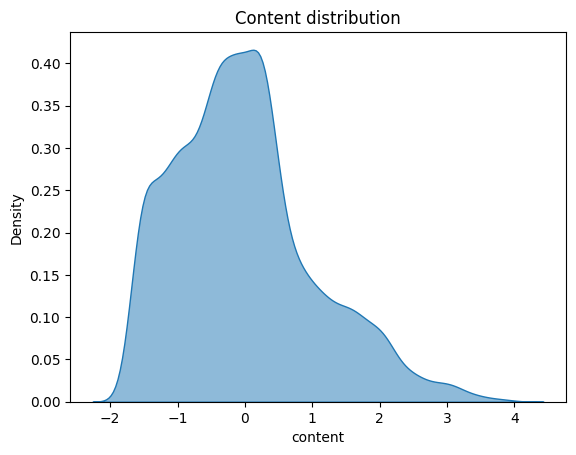

In [18]:
sns.kdeplot(data=train_df, x="content", alpha=.5, fill=True)
plt.title("Content distribution")

Text(0.5, 1.0, 'Wording Score distribution')

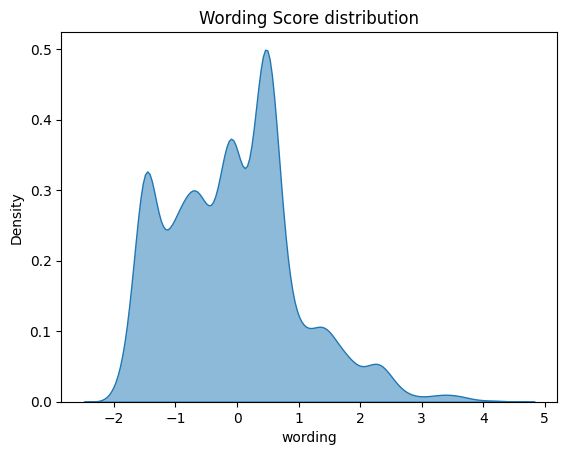

In [19]:
sns.kdeplot(data=train_df, x="wording", alpha=.5, fill=True)
plt.title("Wording Score distribution")

<Axes: xlabel='content', ylabel='wording'>

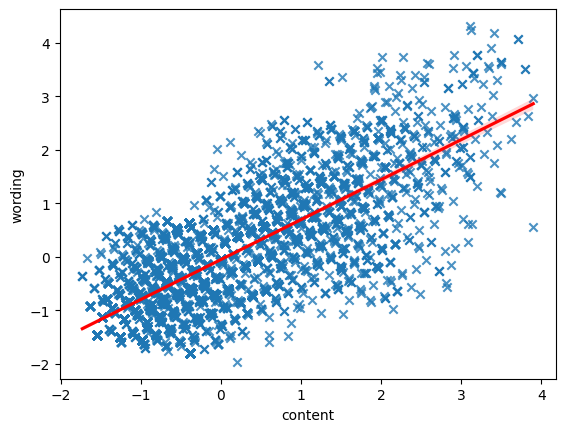

In [20]:
sns.regplot(
    data=train_df, x="content", y="wording",
    ci=99, marker="x", line_kws=dict(color="r"),
)

# **Evaluation**

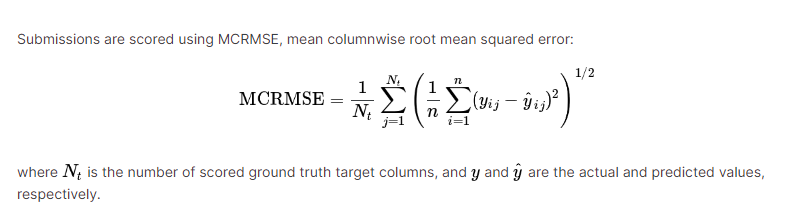

# **Preprocessing and feature engineering**

After lecture second I see that content and wording require different preprocessing techniques.
At first I would like to add spellcheck for both targets.(Also want to add error_count as new feature further for both targets, because I think it might be useful in both cases, because of students, who have good marks for content have a higher chance to have good score for wording, because of the tendency that good students get good grades on different assignments)
Then I should try using lemmatization for training model for predicting the content score. I think that using it for scoring wording may lead to bad results.
In addition I think we may try to use different tokenization for predicting wording and content. In my opinion it might  be useful to apply sentence tokenization to document, which will be used to train 'content' model, because of it it important to us to capture the essence of the text, whereas for 'wording' we can try to use word tokenization to focus on word as unit, what we particulary need here. Also we probably should not use lower case for 'wording' because of obvious reasons, whereas it has no influence on 'content' target.

#  Also I thought it may be a good idea to add similiarity scores between summaries texts and prompt titles, questions and texts.

In [21]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=6cacd671be829e647eb2aa1bb153cc34e68efb2ed48a9e49f7e0293408876bf5
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [22]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

prompt_question_embeddings = model.encode(prompts_train['prompt_question'])
prompt_title_embeddings = model.encode(prompts_train['prompt_title'])
prompt_text_embeddings = model.encode(prompts_train['prompt_text'])

summary_embeddings = model.encode(summaries_train['text'])

prompt_question_embeddings_test = model.encode(prompts_test['prompt_question'])
prompt_title_embeddings_test = model.encode(prompts_test['prompt_title'])
prompt_text_embeddings_test = model.encode(prompts_test['prompt_text'])

summary_embeddings_test = model.encode(summaries_test['text'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/224 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
for i, prompt_id in enumerate(summaries_train['prompt_id'].unique()):
    temp_sum = summary_embeddings[summaries_train[summaries_train['prompt_id']==prompt_id].index]
    temp_que = prompt_question_embeddings[i]
    temp_tit = prompt_title_embeddings[i]
    temp_tex = prompt_text_embeddings[i]
    summaries_train.loc[summaries_train['prompt_id']==prompt_id, "que_score"] = np.array((util.cos_sim(temp_sum, temp_que)))
    summaries_train.loc[summaries_train['prompt_id']==prompt_id, "tit_score"] = np.array((util.cos_sim(temp_sum, temp_tit)))
    summaries_train.loc[summaries_train['prompt_id']==prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
    
for i, prompt_id in enumerate(summaries_test['prompt_id'].unique()):
    temp_sum = summary_embeddings_test[summaries_test[summaries_test['prompt_id']==prompt_id].index]
    temp_que = prompt_question_embeddings_test[i]
    temp_tit = prompt_title_embeddings_test[i]
    temp_tex = prompt_text_embeddings_test[i]
    summaries_test.loc[summaries_test['prompt_id']==prompt_id, "que_score"] = np.array((util.cos_sim(temp_sum, temp_que)))
    summaries_test.loc[summaries_test['prompt_id']==prompt_id, "tit_score"] = np.array((util.cos_sim(temp_sum, temp_tit)))
    summaries_test.loc[summaries_test['prompt_id']==prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))

In [24]:
display(summaries_train.head())
display(summaries_test.head())

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  que_score  tit_score  tex_score  
0  0.205683  0.380538   0.202347   0.172046   0.125049  
1 -0.548304  0.506755  -0.024387   0.009654   0.163209  
2  3.128928  4.231226   0.002855  -0.027881   0.063377  
3 -0.210614 -0.471415   0.054003   0.068688   0.135049  
4  3.272894  3.219757   0.131631   0.123107   0.071256

student_id prompt_id            text  que_score  tit_score  tex_score
0  000000ffffff    abc123  Example text 1   0.266717   0.687386   0.538123
1  111111eeeeee    def789  Example text 2   0.262000   0.684334   0.549948
2  222222cccccc    abc123  Example text 3   0.293968   0.648018   0.565012
3  333333dddddd    def789  Example text 4   0.273473   0.599899   0.565448

In [25]:
train_df = pd.merge(summaries_train, prompts_train, on="prompt_id", how="inner")
train_df.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording  que_score  tit_score  tex_score  \
0  0.205683  0.380538   0.202347   0.172046   0.125049   
1  3.272894  3.219757   0.131631   0.123107   0.071256   
2  0.205683  0.380538   0.059079   0.087925   0.021203   
3  0.567975  0.969062   0.155337   0.246791   0.234451   
4 -0.910596 -0.081769   0.138692   0.118818   0.073937   

                                     prompt_question    prompt_title  \
0  Summarize how the Third Wave developed over su...  The Third Wave   
1  Summarize how the Third Wave developed over su...  The Third Wave   
2  Summarize how the Third Wave developed over su...  The Third Wave   
3  Summarize how the Third Wave developed over su...  The Third Wave   
4  Summarize how the Third Wave developed over su...  The Third Wave   

                                         prompt_text  
0  Background \r\nThe Third Wave experiment took ...  
1  Background \r\nThe Third Wave experiment took ...  
2  Background \r\nThe Third Wave experiment took ...  
3  Background \r\nThe Third Wave experiment took ...  
4  Background \r\nThe Third Wave experiment took ...

In [26]:
test_df = pd.merge(summaries_test, prompts_test, on="prompt_id", how="inner")
test_df.head()

student_id prompt_id            text  que_score  tit_score  tex_score  \
0  000000ffffff    abc123  Example text 1   0.266717   0.687386   0.538123   
1  222222cccccc    abc123  Example text 3   0.293968   0.648018   0.565012   
2  111111eeeeee    def789  Example text 2   0.262000   0.684334   0.549948   
3  333333dddddd    def789  Example text 4   0.273473   0.599899   0.565448   

  prompt_question     prompt_title       prompt_text  
0    Summarize...  Example Title 1  Heading\nText...  
1    Summarize...  Example Title 1  Heading\nText...  
2    Summarize...  Example Title 2  Heading\nText...  
3    Summarize...  Example Title 2  Heading\nText...

In [27]:
train_df["is_train"] = True
test_df["is_train"] = False

train_test = pd.concat([train_df, test_df]).reset_index(drop=True)
train_test.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording  que_score  tit_score  tex_score  \
0  0.205683  0.380538   0.202347   0.172046   0.125049   
1  3.272894  3.219757   0.131631   0.123107   0.071256   
2  0.205683  0.380538   0.059079   0.087925   0.021203   
3  0.567975  0.969062   0.155337   0.246791   0.234451   
4 -0.910596 -0.081769   0.138692   0.118818   0.073937   

                                     prompt_question    prompt_title  \
0  Summarize how the Third Wave developed over su...  The Third Wave   
1  Summarize how the Third Wave developed over su...  The Third Wave   
2  Summarize how the Third Wave developed over su...  The Third Wave   
3  Summarize how the Third Wave developed over su...  The Third Wave   
4  Summarize how the Third Wave developed over su...  The Third Wave   

                                         prompt_text  is_train  
0  Background \r\nThe Third Wave experiment took ...      True  
1  Background \r\nThe Third Wave experiment took ...      True  
2  Background \r\nThe Third Wave experiment took ...      True  
3  Background \r\nThe Third Wave experiment took ...      True  
4  Background \r\nThe Third Wave experiment took ...      True

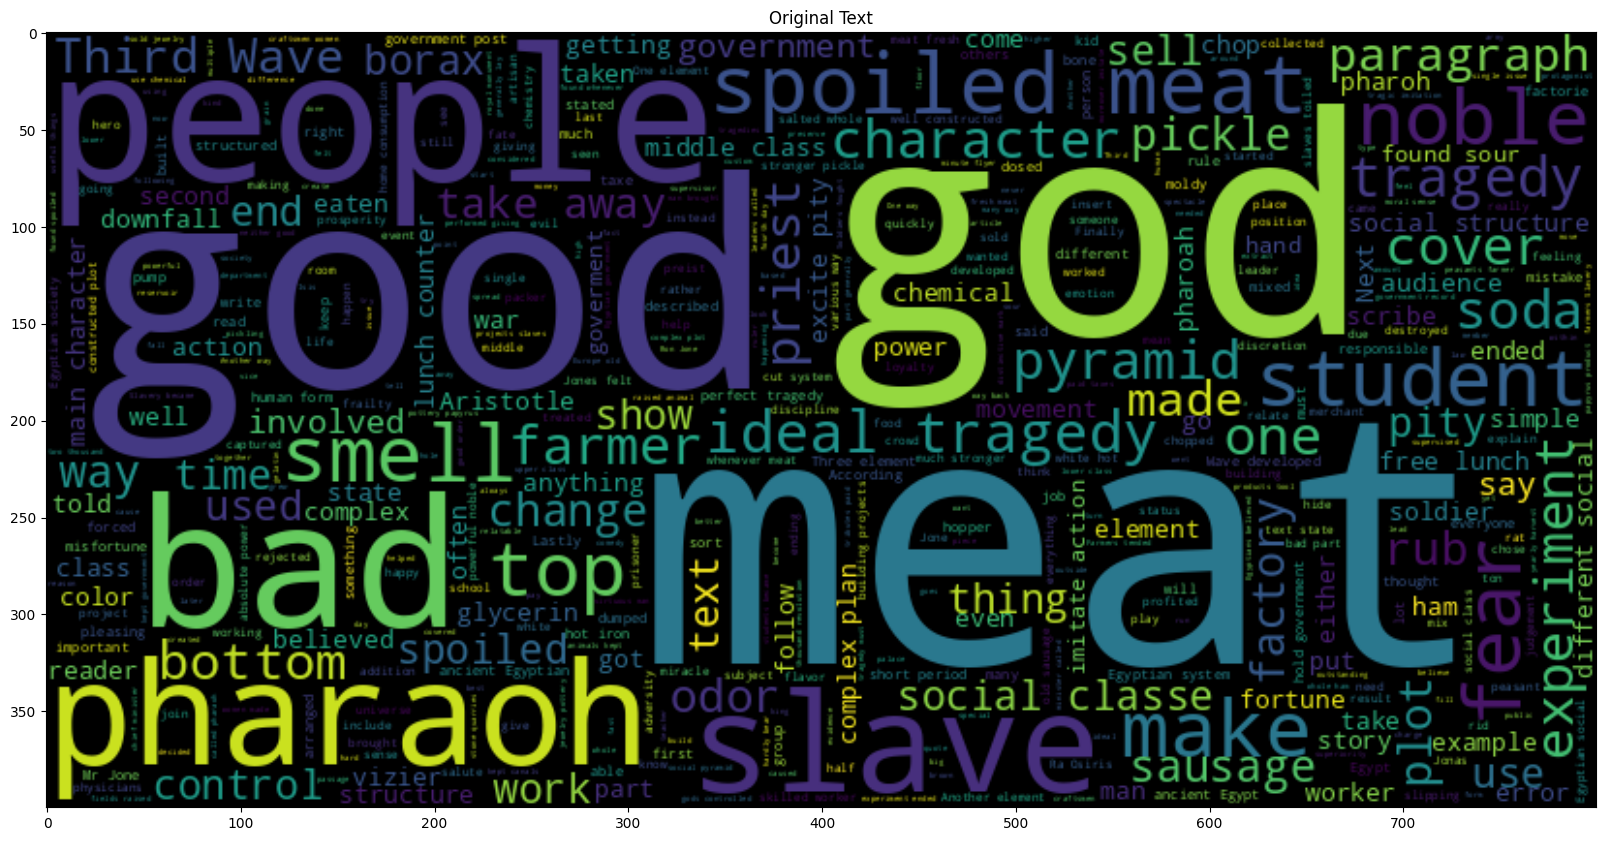

In [28]:
plt.figure(figsize = (20,20)) 
plt.title("Original Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['text']))
plt.imshow(wc, interpolation = 'bilinear')

I decided to look at most frequent words to see what I need to provide during preprocessing.
I see that I don't have something like links or special symbols and it is predictable because of type of our texts.

In [29]:
!pip install pyspellchecker

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.8 MB/s eta 0:00:00


In [30]:
!pip install autocorrect

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=5ecec7bea219e1d76cd317efadaf87c21277d1c6f0fded2956aae0c6e0cede61
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [31]:
from spellchecker import SpellChecker
from autocorrect import Speller


# Preprocess for wording

In [32]:
nltk.download('stopwords')

stop_words = stopwords.words('english')

def wording_preprocessing(text, join_back=True):
    result = []
    
    sentences = sent_tokenize(text)
    sentences = [re.sub(r'[^\w\s.]', '', sentence) for sentence in sentences] 
    sentences = [collapse_dots(sentence) for sentence in sentences]
    sentences = [sentence.strip() for sentence in sentences]

    
    for sentence in sentences:

        words = word_tokenize(sentence)

        remove_stopwords = [word for word in words if word.lower() not in stop_words]

        filtered_sentence = " ".join(remove_stopwords)
        result.append(filtered_sentence)

    return " ".join(result)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocess for content

# **Lemmatization**

In [33]:
import spacy

nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

In [34]:
train_test['lemm_text'] = train_test['text']

In [35]:
train_test

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0070c9e7af47    814d6b   
2     0095993991fe    814d6b   
3     00c20c6ddd23    814d6b   
4     00d40ad10dc9    814d6b   
...            ...       ...   
7164  ffe4a98093b2    39c16e   
7165  000000ffffff    abc123   
7166  222222cccccc    abc123   
7167  111111eeeeee    def789   
7168  333333dddddd    def789   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
2     The third wave only started as an experiment w...  0.205683  0.380538   
3     The experimen was orginally about how even whe...  0.567975  0.969062   
4     The third wave developed so quickly due to the... -0.910596 -0.081769   
...                                                 ...       ...       ...   
7164  An ideal tragety has three elements that make ... -0.393310  0.627128   
7165                                     Example text 1       NaN       NaN   
7166                                     Example text 3       NaN       NaN   
7167                                     Example text 2       NaN       NaN   
7168                                     Example text 4       NaN       NaN   

      que_score  tit_score  tex_score  \
0      0.202347   0.172046   0.125049   
1      0.131631   0.123107   0.071256   
2      0.059079   0.087925   0.021203   
3      0.155337   0.246791   0.234451   
4      0.138692   0.118818   0.073937   
...         ...        ...        ...   
7164   0.112473   0.163173   0.108049   
7165   0.266717   0.687386   0.538123   
7166   0.293968   0.648018   0.565012   
7167   0.262000   0.684334   0.549948   
7168   0.273473   0.599899   0.565448   

                                        prompt_question     prompt_title  \
0     Summarize how the Third Wave developed over su...   The Third Wave   
1     Summarize how the Third Wave developed over su...   The Third Wave   
2     Summarize how the Third Wave developed over su...   The Third Wave   
3     Summarize how the Third Wave developed over su...   The Third Wave   
4     Summarize how the Third Wave developed over su...   The Third Wave   
...                                                 ...              ...   
7164  Summarize at least 3 elements of an ideal trag...       On Tragedy   
7165                                       Summarize...  Example Title 1   
7166                                       Summarize...  Example Title 1   
7167                                       Summarize...  Example Title 2   
7168                                       Summarize...  Example Title 2   

                                            prompt_text  is_train  \
0     Background \r\nThe Third Wave experiment took ...      True   
1     Background \r\nThe Third Wave experiment took ...      True   
2     Background \r\nThe Third Wave experiment took ...      True   
3     Background \r\nThe Third Wave experiment took ...      True   
4     Background \r\nThe Third Wave experiment took ...      True   
...                                                 ...       ...   
7164  Chapter 13 \r\nAs the sequel to what has alrea...      True   
7165                                   Heading\nText...     False   
7166                                   Heading\nText...     False   
7167                                   Heading\nText...     False   
7168                                   Heading\nText...     False   

                                              lemm_text  
0     The third wave was an experimentto see how peo...  
1     The Third Wave developed  rapidly because the ...  
2     The third wave only started as an experiment w...  
3     The experimen was orginally about how even whe...  
4     The third wave developed so quickly due to the...  
...                                                 ...  
7164  An ideal tragety has three 

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
for idx, row in enumerate(train_test['text']):
    train_test['lemm_text'][idx] = lemmatize_text(row)

In [38]:
train_test['lemm_promt_text'] = train_test['prompt_text']

In [39]:
for idx, row in enumerate(train_test['prompt_text']):
    train_test['lemm_promt_text'][idx] = lemmatize_text(row)

In [40]:
 train_test['lemm_promt_question'] =  train_test['prompt_question']

In [41]:
for idx, row in enumerate(train_test['prompt_question']):
    train_test['lemm_promt_question'][idx]= lemmatize_text(row)

# **Check/correct spelling**

In [42]:
from spellchecker import SpellChecker

spell_checker = SpellChecker()

def spell_check_and_correct(text):
    corrected_text = ""
    if isinstance(text, str):
        corrected_text = spell_checker.correction(text)
    return corrected_text

In [43]:
train_test['text'][0]

'The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader'

In [44]:
spell_check_and_correct(train_test['text'][0])

'The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader'

# **Content preprocessing**

In [45]:
def content_preprocessing(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r'[^\w\s.]|\r', '', input) 
        input = collapse_dots(input)
        input = input.strip()
        input = input.lower()
        input = spell_check_and_correct(input)

        
        return input

In [46]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
train_test["wording_preprocessing_text"] = train_test['text'].apply(wording_preprocessing)
train_test["wording_preprocessing_prompt_text"] = train_test['prompt_text'].apply(wording_preprocessing)
train_test["wording_preprocessing_prompt_question"] = train_test['prompt_question'].apply(wording_preprocessing)

In [48]:
train_test["content_preprocessing_text"] = train_test['lemm_text'].apply(content_preprocessing)
train_test["content_preprocessing_prompt_text"] = train_test['lemm_promt_text'].apply(content_preprocessing)
train_test["content_preprocessing_prompt_question"] = train_test['lemm_promt_question'].apply(content_preprocessing)

In [49]:
train_test["content_preprocessing_text"][7165:7169] = train_test["text"][7165:7169]
train_test["content_preprocessing_prompt_text"][7165:7169] = train_test["prompt_text"][7165:7169]
train_test["content_preprocessing_prompt_question"][7165:7169] = train_test["prompt_question"][7165:7169]

In [50]:
idx = 10

print(
    f"Before : {train_test['text'].iloc[idx]}\n"
    f"wording_preprocessing_text : {train_test['wording_preprocessing_text'].iloc[idx]}\n"
    f"content_preprocessing_text : {train_test['content_preprocessing_text'].iloc[idx]}\n"
)
print(
    f"Before : {train_test['prompt_text'].iloc[idx]}\n"
    f"wording_preprocessing_prompt_text : {train_test['wording_preprocessing_prompt_text'].iloc[idx]}\n"
    f"content_preprocessing_prompt_text : {train_test['content_preprocessing_prompt_text'].iloc[idx]}\n"
)
print(
    f"Before : {train_test['prompt_question'].iloc[idx]}\n"
    f"wording_preprocessing_prompt_question : {train_test['wording_preprocessing_prompt_question'].iloc[idx]}\n"
    f"content_preprocessing_prompt_question : {train_test['content_preprocessing_prompt_question'].iloc[idx]}\n"
)

Before : The Third Wave started off with the teacher giving small commands to the class to " eliminate democracy" but it was to really show that people follow what the crowd does. Soon as it moved on through the few days more commands were given and kids all over the school started to participate. The experiment was soon ended because Mr. Jones thought it was starting to get out  of hands, so he told everyone it was an experiment.
wording_preprocessing_text : Third Wave started teacher giving small commands class eliminate democracy really show people follow crowd . Soon moved days commands given kids school started participate . experiment soon ended Mr. Jones thought starting get hands told everyone experiment .
content_preprocessing_text : the third wave start off with the teacher give small command to the class to  eliminate democracy  but it be to really show that people follow what the crowd do . soon as it move on through the few day more command be give and kid all over the sch

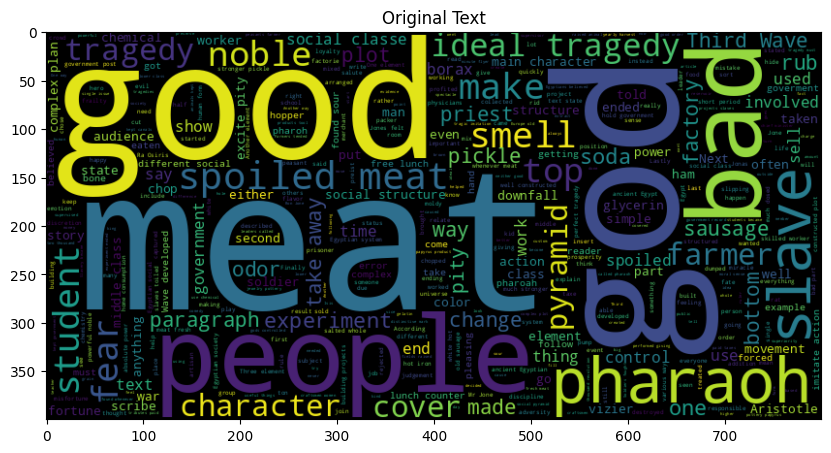

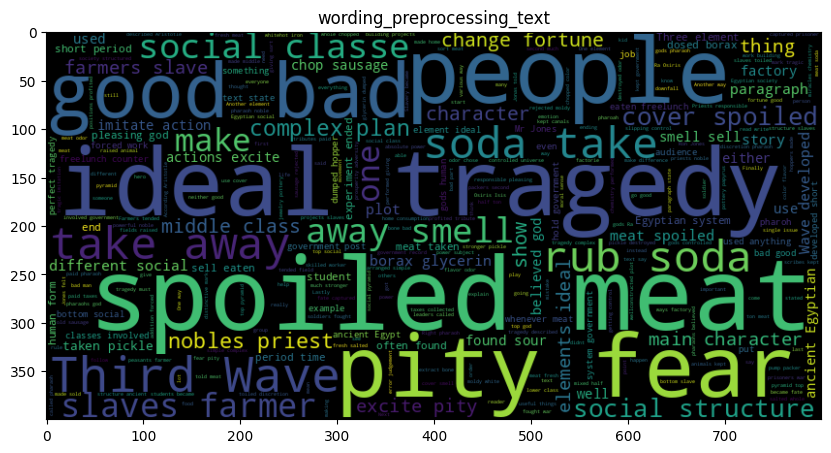

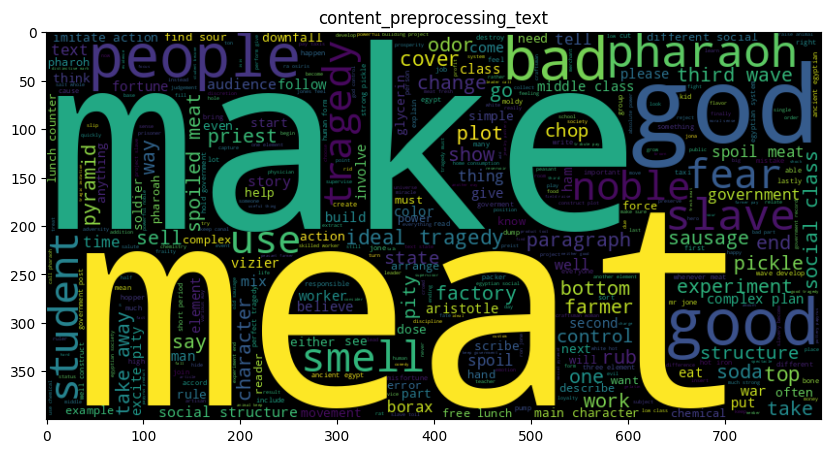

In [51]:
plt.figure(figsize = (10,10)) 
plt.title("Original Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (10,10)) 
plt.title("wording_preprocessing_text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['wording_preprocessing_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (10,10)) 
plt.title("content_preprocessing_text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['content_preprocessing_text']))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [52]:
def count_errors(text: str) -> int:
    return len([1 for word in word_tokenize(text) if not spell_checker.correction(word) == word])

In [53]:
train_test['errors_count'] = train_test['text'].apply(lambda x: count_errors(x))

In [54]:
train_test["n_symbols_w"] = train_test["wording_preprocessing_text"].apply(len)
train_test["n_words_w"] = train_test["wording_preprocessing_text"].apply(lambda x: len(nltk.tokenize.word_tokenize(x)))
train_test["n_sents_w"] = train_test["wording_preprocessing_text"].apply(lambda x: len(nltk.tokenize.sent_tokenize(x)))
train_test['prompt_len_w'] = train_test['wording_preprocessing_prompt_text'].apply(lambda x: len(x.split()))
train_test['length_ratio_w'] = train_test['n_symbols_w'] / train_test['prompt_len_w']

In [55]:
train_test["n_symbols_c"] = train_test["content_preprocessing_text"].apply(len)
train_test["n_words_c"] = train_test["content_preprocessing_text"].apply(lambda x: len(nltk.tokenize.word_tokenize(x)))
train_test["n_sents_c"] = train_test["content_preprocessing_text"].apply(lambda x: len(nltk.tokenize.sent_tokenize(x)))
train_test['prompt_len_c'] = train_test['content_preprocessing_prompt_text'].apply(lambda x: len(x.split()))
train_test['length_ratio_c'] = train_test['n_symbols_c'] / train_test['prompt_len_c']


In [56]:
train_test.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording  que_score  tit_score  tex_score  \
0  0.205683  0.380538   0.202347   0.172046   0.125049   
1  3.272894  3.219757   0.131631   0.123107   0.071256   
2  0.205683  0.380538   0.059079   0.087925   0.021203   
3  0.567975  0.969062   0.155337   0.246791   0.234451   
4 -0.910596 -0.081769   0.138692   0.118818   0.073937   

                                     prompt_question    prompt_title  ...  \
0  Summarize how the Third Wave developed over su...  The Third Wave  ...   
1  Summarize how the Third Wave developed over su...  The Third Wave  ...   
2  Summarize how the Third Wave developed over su...  The Third Wave  ...   
3  Summarize how the Third Wave developed over su...  The Third Wave  ...   
4  Summarize how the Third Wave developed over su...  The Third Wave  ...   

  n_symbols_w  n_words_w n_sents_w prompt_len_w length_ratio_w n_symbols_c  \
0         258         39         4          335       0.770149         332   
1         844        123        13          335       2.519403        1203   
2         239         36         3          335       0.713433         328   
3         293         41         3          335       0.874627         430   
4         104         17         2          335       0.310448         144   

  n_words_c n_sents_c prompt_len_c length_ratio_c  
0        64         4          627       0.529506  
1       219        13          627       1.918660  
2        65         3          627       0.523126  
3        79         3          627       0.685805  
4        29         2          627       0.229665  

[5 rows x 32 columns]

# **Modeling**

In [57]:
train_test["merged_text_content"] = (
    train_test["prompt_title"] + ". " + train_test["content_preprocessing_prompt_question"] + " " +  train_test["content_preprocessing_prompt_text"] + ". " + train_test["content_preprocessing_text"]
)

train_test["merged_text_content"].iloc[10]

'The Third Wave. summarize how the third wave develop over such a short period of time and why the experiment be end . background \n the third wave experiment take place at cubberley high school in palo alto  california during the first week of april 1967 . history teacher ron jones  find himself unable to explain to his student how people throughout history follow the crowd even when terrible thing be happen  decide to demonstrate it to his student through an experiment . jones announce that he be start a movement aim to eliminate democracy . jones name the movement  the third wave  as a symbol of strength  refer to the mythical belief that the third in a series of wave be the strong . one of the central point of this movement be that democracy s main weakness be that it favor the individual over the whole community . jones emphasize this main point of the movement when he create this catchy motto   strength through discipline  strength through community  strength through action  stre

 I will train model without using prompts features in order to avoid increasing noise in the model, because to predict wording we need only student's texts.

In [58]:
train_test["merged_text_wording"] = (
    train_test["wording_preprocessing_prompt_text"] + ". " + train_test["wording_preprocessing_text"]
)

train_test["merged_text_content"].iloc[10]

'The Third Wave. summarize how the third wave develop over such a short period of time and why the experiment be end . background \n the third wave experiment take place at cubberley high school in palo alto  california during the first week of april 1967 . history teacher ron jones  find himself unable to explain to his student how people throughout history follow the crowd even when terrible thing be happen  decide to demonstrate it to his student through an experiment . jones announce that he be start a movement aim to eliminate democracy . jones name the movement  the third wave  as a symbol of strength  refer to the mythical belief that the third in a series of wave be the strong . one of the central point of this movement be that democracy s main weakness be that it favor the individual over the whole community . jones emphasize this main point of the movement when he create this catchy motto   strength through discipline  strength through community  strength through action  stre

In [59]:
train_test

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0070c9e7af47    814d6b   
2     0095993991fe    814d6b   
3     00c20c6ddd23    814d6b   
4     00d40ad10dc9    814d6b   
...            ...       ...   
7164  ffe4a98093b2    39c16e   
7165  000000ffffff    abc123   
7166  222222cccccc    abc123   
7167  111111eeeeee    def789   
7168  333333dddddd    def789   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
2     The third wave only started as an experiment w...  0.205683  0.380538   
3     The experimen was orginally about how even whe...  0.567975  0.969062   
4     The third wave developed so quickly due to the... -0.910596 -0.081769   
...                                                 ...       ...       ...   
7164  An ideal tragety has three elements that make ... -0.393310  0.627128   
7165                                     Example text 1       NaN       NaN   
7166                                     Example text 3       NaN       NaN   
7167                                     Example text 2       NaN       NaN   
7168                                     Example text 4       NaN       NaN   

      que_score  tit_score  tex_score  \
0      0.202347   0.172046   0.125049   
1      0.131631   0.123107   0.071256   
2      0.059079   0.087925   0.021203   
3      0.155337   0.246791   0.234451   
4      0.138692   0.118818   0.073937   
...         ...        ...        ...   
7164   0.112473   0.163173   0.108049   
7165   0.266717   0.687386   0.538123   
7166   0.293968   0.648018   0.565012   
7167   0.262000   0.684334   0.549948   
7168   0.273473   0.599899   0.565448   

                                        prompt_question     prompt_title  ...  \
0     Summarize how the Third Wave developed over su...   The Third Wave  ...   
1     Summarize how the Third Wave developed over su...   The Third Wave  ...   
2     Summarize how the Third Wave developed over su...   The Third Wave  ...   
3     Summarize how the Third Wave developed over su...   The Third Wave  ...   
4     Summarize how the Third Wave developed over su...   The Third Wave  ...   
...                                                 ...              ...  ...   
7164  Summarize at least 3 elements of an ideal trag...       On Tragedy  ...   
7165                                       Summarize...  Example Title 1  ...   
7166                                       Summarize...  Example Title 1  ...   
7167                                       Summarize...  Example Title 2  ...   
7168                                       Summarize...  Example Title 2  ...   

     n_sents_w  prompt_len_w length_ratio_w n_symbols_c n_words_c n_sents_c  \
0            4           335       0.770149         332        64         4   
1           13           335       2.519403        1203       219        13   
2            3           335       0.713433         328        65         3   
3            3           335       0.874627         430        79         3   
4            2           335       0.310448         144        29         2   
...        ...           ...            ...         ...       ...       ...   
7164         3           302       0.668874         294        62         3   
7165         1             3       4.666667          14         3         1   
7166         1             3       4.666667          14         3         1   
7167         1             3       4.666667          14         3         1   
7168         1             3       4.666667          14         3         1   

     prompt_len_c length_ratio_c  \
0             627       0.529506   
1             627       1.918660   
2             627       0.523126   
3             627       0.685805   
4             627       0.229665   
...           ...            ...   
7164   

In [60]:
wording_training_cols = ['merged_text_wording', 'n_symbols_w', 'n_words_w', 'n_sents_w', 'prompt_len_w', 'length_ratio_w', 'que_score', 'tit_score', 'tex_score', 'errors_count']
content_training_cols = ['merged_text_content', 'n_symbols_c', 'n_words_c', 'n_sents_c', 'prompt_len_c', 'length_ratio_c', 'que_score', 'tit_score', 'tex_score', 'errors_count']

In [61]:
train_test[wording_training_cols].head()

merged_text_wording  n_symbols_w  n_words_w  \
0  Background Third Wave experiment took place Cu...          258         39   
1  Background Third Wave experiment took place Cu...          844        123   
2  Background Third Wave experiment took place Cu...          239         36   
3  Background Third Wave experiment took place Cu...          293         41   
4  Background Third Wave experiment took place Cu...          104         17   

   n_sents_w  prompt_len_w  length_ratio_w  que_score  tit_score  tex_score  \
0          4           335        0.770149   0.202347   0.172046   0.125049   
1         13           335        2.519403   0.131631   0.123107   0.071256   
2          3           335        0.713433   0.059079   0.087925   0.021203   
3          3           335        0.874627   0.155337   0.246791   0.234451   
4          2           335        0.310448   0.138692   0.118818   0.073937   

   errors_count  
0             2  
1            21  
2             7  
3             6  
4             2

In [62]:
train_test[content_training_cols].head()

merged_text_content  n_symbols_c  n_words_c  \
0  The Third Wave. summarize how the third wave d...          332         64   
1  The Third Wave. summarize how the third wave d...         1203        219   
2  The Third Wave. summarize how the third wave d...          328         65   
3  The Third Wave. summarize how the third wave d...          430         79   
4  The Third Wave. summarize how the third wave d...          144         29   

   n_sents_c  prompt_len_c  length_ratio_c  que_score  tit_score  tex_score  \
0          4           627        0.529506   0.202347   0.172046   0.125049   
1         13           627        1.918660   0.131631   0.123107   0.071256   
2          3           627        0.523126   0.059079   0.087925   0.021203   
3          3           627        0.685805   0.155337   0.246791   0.234451   
4          2           627        0.229665   0.138692   0.118818   0.073937   

   errors_count  
0             2  
1            21  
2             7  
3             6  
4             2

In [63]:
x_train_word, x_test_word, y_train_word, y_test_word = train_test_split(
    train_test.loc[train_test["is_train"], 'merged_text_wording'],
    train_test.loc[train_test["is_train"], "wording"],
    test_size=0.2,random_state=1
)

In [64]:
x_train_content, x_test_content, y_train_content, y_test_content = train_test_split(
    train_test.loc[train_test["is_train"], 'merged_text_content'],
    train_test.loc[train_test["is_train"], "content"],
    test_size=0.2,random_state=1
)

In [65]:
def rmse(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.mean((x - y)**2))

In [66]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=1,
        max_features=30000
    )),
    ('regressor', Ridge())
])


param_grid = {
    'regressor__alpha': [0.1, 0.5, 1.0, 10.0],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)


grid_search.fit(x_train_word, y_train_word)


best_alpha = grid_search.best_params_['regressor__alpha']
best_max_df = grid_search.best_params_['tfidf__max_df']
best_min_df = grid_search.best_params_['tfidf__min_df']
best_ngram_range = grid_search.best_params_['tfidf__ngram_range']





Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [67]:
from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
    ('bow', CountVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=1,
        max_features=30000
    )),
    ('regressor', Ridge())
])


param_grid = {
    'regressor__alpha': [0.1, 0.5, 1.0, 10.0],
    'bow__max_df': [0.9, 0.95],
    'bow__min_df': [1, 2],
    'bow__ngram_range': [(1, 3)],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(x_train_content, y_train_content)



Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(max_features=30000,
                                                        ngram_range=(1, 3),
                                                        stop_words='english')),
                                       ('regressor', Ridge())]),
             param_grid={'bow__max_df': [0.9, 0.95], 'bow__min_df': [1, 2],
                         'bow__ngram_range': [(1, 3)],
                         'regressor__alpha': [0.1, 0.5, 1.0, 10.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [68]:
best_alpha_bow = grid_search.best_params_['regressor__alpha']
best_max_df_bow = grid_search.best_params_['bow__max_df']
best_min_df_bow = grid_search.best_params_['bow__min_df']
best_ngram_range_bow = grid_search.best_params_['bow__ngram_range']

print("Best Alpha:", best_alpha_bow)
print("Best max_df:", best_max_df_bow)
print("Best min_df:", best_min_df_bow)
print("Best ngram_range:", best_ngram_range)


Best Alpha: 10.0
Best max_df: 0.9
Best min_df: 1
Best ngram_range: (1, 3)


In [69]:
best_alpha_tf = grid_search.best_params_['regressor__alpha']
best_max_df_tf = grid_search.best_params_['tfidf__max_df']
best_min_df_tf = grid_search.best_params_['tfidf__min_df']
best_ngram_range_tf = grid_search.best_params_['tfidf__ngram_range']
best_alpha_tf, best_max_df_tf, best_min_df_tf, best_ngram_range_tf, best_ngram_range_tf

KeyError: 'tfidf__max_df'

In [ ]:
X_train_tfidf.shape

In [ ]:
best_ridge = Ridge(alpha=best_alpha)


best_tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    ngram_range=best_ngram_range,
    lowercase=True,
    min_df=best_min_df,
    max_df=best_max_df,
    max_features=30000
)

X_train_tfidf = best_tfidf_vectorizer.fit_transform(x_train_word)


best_ridge.fit(x_train_word, y_train_word)

In [ ]:
# Transform the test data using the best TF-IDF vectorizer
X_test_tfidf = best_tfidf_vectorizer.transform(x_test_word)

# Make predictions on the test data
y_pred = best_ridge.predict(X_test_tfidf)

# Evaluate your model as needed (e.g., calculate RMSE)
rmse(y_test_word, y_pred)

In [ ]:
# Fit the best model on the entire training data
best_ridge.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_ridge.predict(X_test)

In [ ]:
predictions_train_test = pipeline.predict(x_train_test)
predictions_train_train = pipeline.predict(x_train_train)

In [ ]:
train_content_rmse = rmse(y_train_train.iloc[:,0], predictions_train_train[:,0])
train_wording_rmse = rmse(y_train_train.iloc[:,1], predictions_train_train[:,1])
test_content_rmse = rmse(y_train_test.iloc[:,0], predictions_train_test[:,0])
test_wording_rmse = rmse(y_train_test.iloc[:,1], predictions_train_test[:,1])

In [ ]:
MCRMSE_train = (train_content_rmse + train_wording_rmse) / 2
print(f"Train MCRMSE = {MCRMSE_train}")

In [ ]:
MCRMSE_test = (test_content_rmse + test_wording_rmse) / 2
print(f"Test MCRMSE = {MCRMSE_test}")

In [ ]:
predictions_test = pipeline.predict(train_test.loc[~train_test["is_train"],"merged_text"])

In [ ]:
test_df = train_test.loc[~train_test["is_train"]].copy()
test_df[["content", "wording"]] = predictions_test

In [ ]:
test_df[['student_id', 'content', 'wording']].to_csv('submission.csv',index=False)

In [ ]:
test_df